# fsAverage

This notebook is designed to read a collection of subjects from the York dataset and average the values across subjects.

In [1]:
import nibabel as nib
import numpy as np
import matplotlib.pylab as plt
import seaborn as sb
import scipy as sp
import pandas as pd
%matplotlib inline
sb.set_context('notebook')
# R2590 is one of the subjects
R2590_FILE_PATH = 'YORK_processing/R2590/pRFs/lh.pol.sym.nii.gz'

In [2]:
AVERAGES_DIR = "averages"
!mkdir -p {AVERAGES_DIR}

Loading 1 nifti surface image using `nibabel` to demonstrate that it works. Note that the matrix is 1-dimensional as this is a surface file.

Dimensions: (163842, 1, 1)


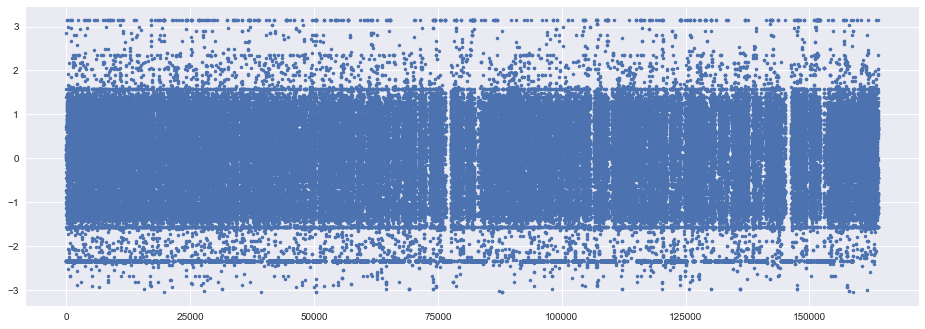

In [44]:
lh_pol = nib.load(R2590_FILE_PATH)
print 'Dimensions:', lh_pol.shape
lh_pol_data = lh_pol.get_data()

plt.figure(figsize=(16.0, 5.5))
plt.plot(lh_pol_data.flatten(), '.');

Dimensions: (163842, 1, 1)


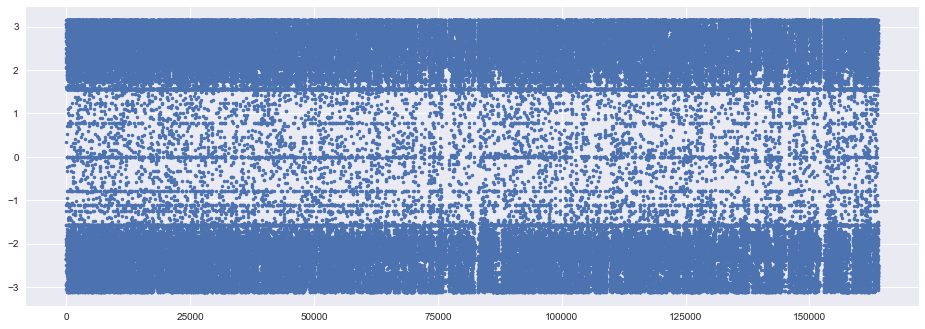

In [47]:
rh_pol = nib.load('YORK_processing/R2590/pRFs/rh.pol.sym.nii.gz')
print 'Dimensions:', rh_pol.shape
rh_pol_data = rh_pol.get_data()

plt.figure(figsize=(16.0, 5.5))
plt.plot(rh_pol_data.flatten(), '.');

## Mirroring right hemisphere polar angle to align with left hemisphere

We've decided to merge the two hemispheres, so the the right hemisphere polar angle needs to be aligned to the left hemisphere. This will be done via mirroring, not rotation.

Mirror: +179° → +1°, −179° → −1°  
Rotate: +179° → −1°, −179° → +1°  

In [58]:
from collections import Counter
import math
lh_count = Counter(rh_pol_data.flatten())
for angle, _ in lh_count.most_common(10):
    print round(math.degrees(angle), 1)

-135.0
180.0
90.0
-90.0
135.0
-116.6
153.4
161.6
-108.4
-153.4


Notice that the variance is much higher in the right hemisphere (rh) than the left hemisphere (lh). This is actually because the right hemisphere is centered around ±$\pi$, so it seems to "jump" around a lot, whereas the left hemisphere is centered around 0.

In [5]:
print 'Right hemisphere variance:', rh_pol_data.var()
print 'Left hemisphere variance:', lh_pol_data.var()

Right hemisphere variance: 5.77374
Left hemisphere variance: 1.68269


First, we assume that all the subjects have directory names that start with R and list them out.

In [6]:
import glob
session_paths = glob.glob('YORK_processing/R*')
session_paths

['YORK_processing/R3262',
 'YORK_processing/R3403',
 'YORK_processing/R2590',
 'YORK_processing/R3395',
 'YORK_processing/R3724',
 'YORK_processing/R3052',
 'YORK_processing/R3269',
 'YORK_processing/R3534',
 'YORK_processing/R3532',
 'YORK_processing/R3391',
 'YORK_processing/R3074',
 'YORK_processing/R3271',
 'YORK_processing/R3738',
 'YORK_processing/R3557',
 'YORK_processing/R3404',
 'YORK_processing/R3267',
 'YORK_processing/R3554',
 'YORK_processing/R3254',
 'YORK_processing/R3261',
 'YORK_processing/R3531',
 'YORK_processing/R2595']

Each subject has 8 files: 4 for each hemisphere, left (`lh`) and right (`rh`). In each hemisphere, there is `co` for correlation (calculated during fit), `ecc` for eccentricity, `pol` for polar angle, and `sig` for sigma. The following code just generates the list of files.

In [7]:
import itertools
# 'pol' left out because we want to do circular mean
file_path_prefix = itertools.product(['lh', 'rh'], ['co', 'ecc', 'sig'])
file_paths = ["pRFs/" + pre[0] + '.' + pre[1] + '.sym.nii.gz' for pre in file_path_prefix]
circ_paths = ['pRFs/lh.pol.sym.nii.gz', 'pRFs/rh.pol.sym.nii.gz']
file_paths

['pRFs/lh.co.sym.nii.gz',
 'pRFs/lh.ecc.sym.nii.gz',
 'pRFs/lh.sig.sym.nii.gz',
 'pRFs/rh.co.sym.nii.gz',
 'pRFs/rh.ecc.sym.nii.gz',
 'pRFs/rh.sig.sym.nii.gz']

To test out the average, we will be using `file_paths[0]`, which is `lh.co.sym.nii.gz`, the left hemisphere's correlation. The 0 axis is of length 163842, and the result `avg` is a 163842×1×1 matrix containing the average of all the subjects.

In [8]:
import os.path
img_paths = (os.path.join(sess, file_paths[0]) for sess in session_paths)
imgs = [nib.load(path) for path in img_paths]
imgs_data = [img.get_data() for img in imgs]
avg = np.mean(imgs_data, axis=0)
affine_data = [img.affine for img in imgs]
affine_avg = np.mean(affine_data, axis=0)
avg

array([[[        nan]],

       [[ 0.22040156]],

       [[        nan]],

       ..., 
       [[ 0.14393064]],

       [[ 0.14158241]],

       [[ 0.15303762]]], dtype=float32)

Next, we can redo this code by looping over all the different `file_paths` to do both hemispheres and each of the 3 metrics with a simple mean.

The left and right hemisphere maps have been generated using the appropriate right and left visual stimulation data, so there is no need to identify which is the "correct" one.

**TODO**: Use explained variance to weigh patients' data in mean. Can be done with `np.average` instead of `np.mean`.

In [9]:
# Do simple mean

for nifti in file_paths:
    img_paths = (os.path.join(sess, nifti) for sess in session_paths)
    imgs = [nib.load(path) for path in img_paths]
    affine_data = [img.affine for img in imgs]
    affine_avg = np.mean(affine_data, axis=0)
    imgs_data = [img.get_data() for img in imgs]
    avg = np.mean(imgs_data, axis=0)
    avg_file_name = "avg." + nifti.split("/")[1]
    avg_nifti = nib.Nifti1Image(avg, affine_avg)
    avg_nifti.to_filename(os.path.join(AVERAGES_DIR, avg_file_name))

Now, circular means of the polar angle.

In [10]:
polar_angle = pd.DataFrame({"lh": lh_pol_data.flatten(), "rh": rh_pol_data.flatten()})
print polar_angle.mode()
polar_angle.describe()

         lh        rh
0 -2.356194 -2.356194


,lh,rh
count,163842.000000,163842.000000
mean,-0.509644,-0.176957
std,1.297188,2.402868
min,-3.058451,-3.121595
25%,-1.570796,-2.356194
50%,-0.239232,-1.675673
75%,0.540420,2.432966
max,3.141593,3.141593


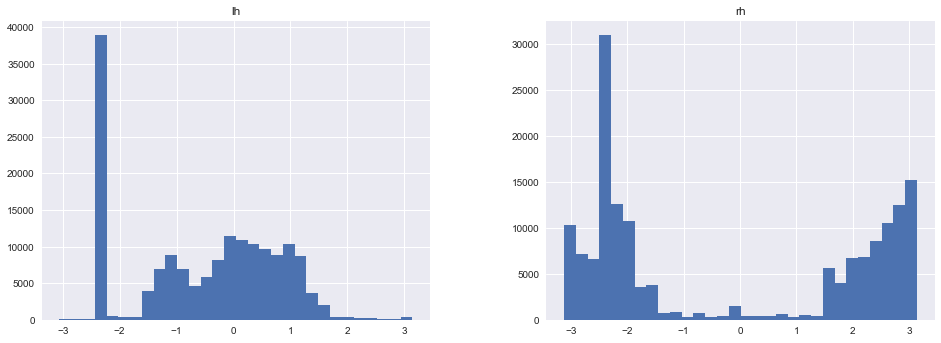

In [11]:
# Histogram of polar angle, massive spike at -135°
polar_angle.hist(bins=30, figsize=(16.0, 5.5));

In [12]:
import math
sp.stats.circmean([-3.14, 3.14], high=math.pi, low=-math.pi)

-3.1415926535897931

In [13]:
# Circular mean for polar angles

for nifti in circ_paths:
    img_paths = (os.path.join(sess, nifti) for sess in session_paths)
    imgs = [nib.load(path) for path in img_paths]
    affine_data = [img.affine for img in imgs]
    affine_avg = np.mean(affine_data, axis=0)
    imgs_data = [img.get_data() for img in imgs]
    avg = sp.stats.circmean(imgs_data, high=math.pi, low=-math.pi, axis=0)
    avg_file_name = "avg." + nifti.split("/")[1]
    avg_nifti = nib.Nifti1Image(avg, affine_avg)
    avg_nifti.to_filename(os.path.join(AVERAGES_DIR, avg_file_name))

The shape file has odd dimensions in Python, with a dimension of -1. Seems to work fine in MATLAB. Needs more investigation.

In [14]:
# img = nib.load('YORK_processing/R2590/pRFs/lh.surf.tcs.nii.gz')
# img.shape

Images do not always have the same affine (what is an affine?)

In [15]:
img1 = nib.load('YORK_processing/R2590/pRFs/lh.ecc.sym.nii.gz')
img2 = nib.load('YORK_processing/R3395/pRFs/lh.ecc.sym.nii.gz')
img1.affine == img2.affine

array([[ True,  True,  True,  True],
       [ True,  True,  True, False],
       [ True,  True,  True, False],
       [ True,  True,  True,  True]], dtype=bool)

## Average Data

In [16]:
lh_avg = nib.load("averages/avg.lh.pol.sym.nii.gz")
rh_avg = nib.load("averages/avg.rh.pol.sym.nii.gz")
polar_angle = pd.DataFrame({"lh": lh_avg.get_data().flatten(), "rh": rh_avg.get_data().flatten()})
polar_angle.describe()

,lh,rh
count,163842.000000,163842.000000
mean,-0.627396,-0.880181
std,0.914566,2.695161
min,-2.995070,-3.141593
25%,-1.126988,-2.909466
50%,-0.240728,-2.576490
75%,0.023438,2.813378
max,2.971708,3.141585


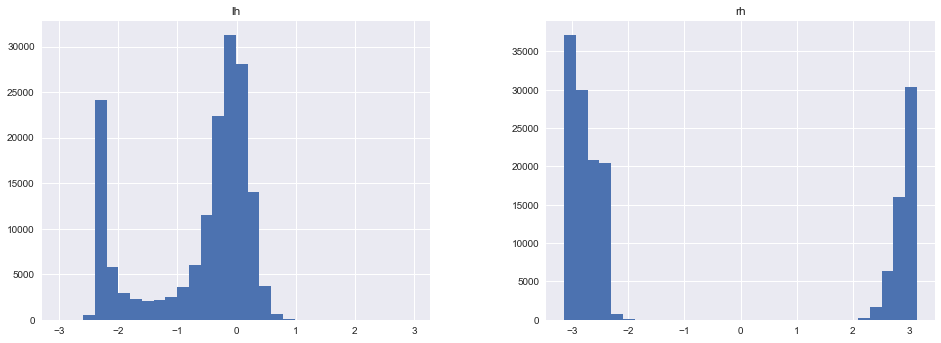

In [17]:
# Histogram of polar angle, massive spike at -135°
polar_angle.hist(bins=30, figsize=(16.0, 5.5));

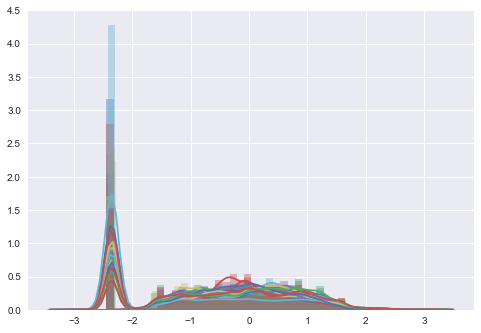

In [34]:
# Circular mean for polar angles on left hemisphere
nifti = circ_paths[0]
for sess in session_paths:
    img_path = os.path.join(sess, nifti)
    img = nib.load(img_path).get_data().flatten()
    sb.distplot(img);

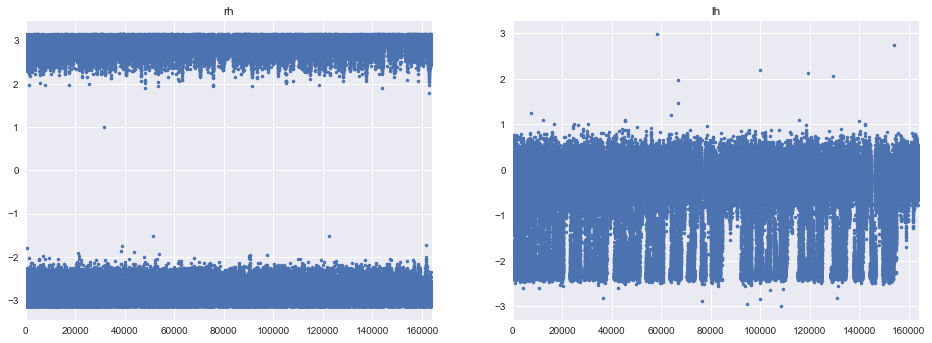

In [39]:
plt.figure(figsize=(16.0, 5.5))
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)
polar_angle['rh'].plot(title="rh", ax=ax1, style=['.']);
polar_angle['lh'].plot(title="lh", ax=ax2, style=['.']);

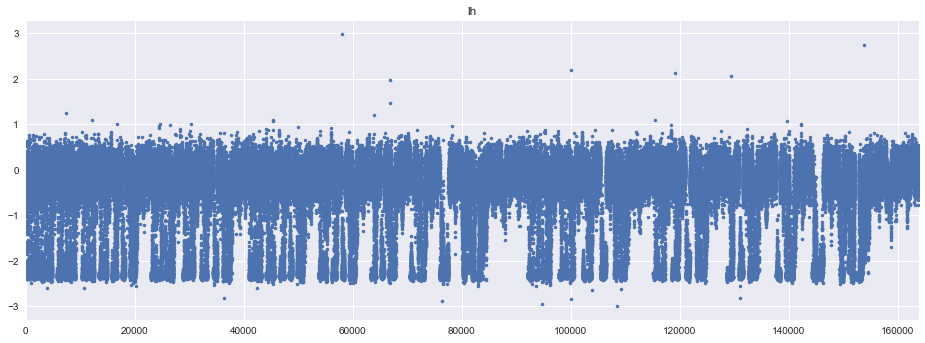

In [41]:
plt.figure(figsize=(16.0, 5.5))
polar_angle['lh'].plot(title="lh", style=['.']);